In [1]:
import sys, glob, itertools
import numpy as np
import qiskit

import networkx as nx
from networkx.algorithms.community.kernighan_lin import kernighan_lin_bisection

import utils.graph_funcs as graph_funcs
import utils.helper_funcs as helper_funcs
import utils.cutting_funcs as cutting_funcs

import qsplit_circuit_cutter as qcc
import qsplit_mlrecon_methods as qmm
import qsplit_dqva_methods as qdm

from ansatz import dqv_cut_ansatz

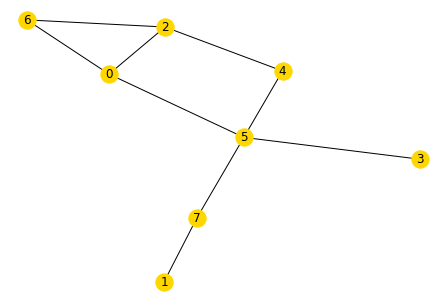

In [2]:
test_graphs = glob.glob("benchmark_graphs/N8_p30_graphs/*")
#test_graph = np.random.choice(test_graphs)
G = graph_funcs.graph_from_file(test_graphs[0])
qubit_num = G.number_of_nodes()
nx.draw_spring(G, with_labels=True, node_color='gold')

Partition: ({1, 3, 5, 7}, {0, 2, 4, 6})
Cut edges: [(5, 4), (0, 5)]
Cut nodes: [5, 4, 0, 5] Hot nodes: [0, 4]


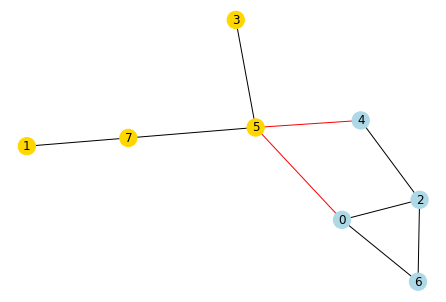

In [3]:
partition = kernighan_lin_bisection(G)
print('Partition:', partition)
subgraphs, cut_edges = graph_funcs.get_subgraphs(G, partition)
cut_nodes, hot_nodes = cutting_funcs.choose_nodes(G, subgraphs, cut_edges, max_cuts=1)
print('Cut edges:', cut_edges)
print('Cut nodes:', cut_nodes, 'Hot nodes:', hot_nodes)
graph_funcs.view_partition(partition, G)

In [6]:
nq = len(G.nodes())
P = 1
init_state = '0'*nq
init_state = '00000000'
print('Initial state:', init_state)

num_params = P * (nq + 1)

mixer_order = list(np.random.permutation(list(G.nodes)))
print('mixer order:', mixer_order)
print()

Initial state: 00000001
params: [Parameter(var_0), Parameter(var_1), Parameter(var_2), Parameter(var_3), Parameter(var_4), Parameter(var_5), Parameter(var_6), Parameter(var_7), Parameter(var_8)]
mixer order: [4, 3, 5, 0, 6, 7, 2, 1]



In [7]:
def get_circuit_and_cuts(num_params, init_state, mixer_order):

    params = [qiskit.circuit.Parameter('var_{}'.format(num)) for num in range(num_params)]
    print('params:', params)

    kwargs = dict(params=params, init_state=init_state, mixer_order=mixer_order,
                  decompose_toffoli=1, verbose=1, P=P, barriers=2)
    
    circuit, cuts = dqv_cut_ansatz.gen_dqva(G, partition, cut_nodes, hot_nodes, **kwargs)
    
    fragments, wire_path_map = qcc.cut_circuit(circuit, cuts)
    
    return fragments, wire_path_map

In [8]:
circuit, cuts, fragments, wire_path_map = get_circuit_and_cuts(num_params, init_state, mixer_order)
circ.draw(fold=-1)

params: [Parameter(var_0), Parameter(var_1), Parameter(var_2), Parameter(var_3), Parameter(var_4), Parameter(var_5), Parameter(var_6), Parameter(var_7), Parameter(var_8)]
Parameters:
	alpha_0: [Parameter(var_0), Parameter(var_1), Parameter(var_2), Parameter(var_3), Parameter(var_4), Parameter(var_5), Parameter(var_6)]
	gamma_0: var_7
	alpha_1: [Parameter(var_8)]
APPLYING MIXER UNITARY
	Mixer order: [4, 0, 6, 2, 3, 5, 7, 1] Cut nodes: [5, 4, 0, 5] Hot nodes: [0, 4]
	init_state: 00000001
	alpha: [Parameter(var_0), Parameter(var_1), Parameter(var_2), Parameter(var_3), Parameter(var_4), Parameter(var_5), Parameter(var_6)]
	pad_alpha: [None, Parameter(var_5), Parameter(var_2), Parameter(var_3), Parameter(var_0), None, Parameter(var_1), Parameter(var_4)]
	Swap qubit = 3
	qubit: 4 num_qubits = 10 neighbors: [2, 5]
	qubit: 6 num_qubits = 10 neighbors: [0, 2]
	qubit: 2 num_qubits = 10 neighbors: [0, 4, 6]
	cuts: [(Qubit(QuantumRegister(8, 'q'), 5), 6)]
	qubit: 3 num_qubits = 10 neighbors: [5]
	

TypeError: 'Qubit' object is not subscriptable